# Segmenting Customer Data using Cluster Analysis  

#### Source: [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

## Which customers are most likely to join customer loyalty program?  

### Customers between the ages of 26-55 with a spending score between 40-80, earning between $ 30k - 90k annually.

In [1]:
from initial_cleaning import initial_cleaning

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_context('notebook', font_scale=1.5)

In [2]:
mall = pd.DataFrame(initial_cleaning('/Users/jamilab/Data_Science/Data_Sets/Mall_Customers.csv'))

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [3]:
# count rows & columns

mall.shape

(200, 5)

In [4]:
# drop customer id column

mall = mall.drop(['CustomerID'], 1)

In [5]:
# rename columns

mall = mall.rename(columns={'Annual Income (k$)' : 'Annual_Income', 'Spending Score (1-100)' : 'Spend_Score'})

In [6]:
# check data types

mall.dtypes

Gender           object
Age               int64
Annual_Income     int64
Spend_Score       int64
dtype: object

In [7]:
mall.describe()

,Age,Annual_Income,Spend_Score
count,200.000,200.000,200.000
mean,38.850,60.560,50.200
std,13.969,26.265,25.824
min,18.000,15.000,1.000
25%,28.750,41.500,34.750
50%,36.000,61.500,50.000
75%,49.000,78.000,73.000
max,70.000,137.000,99.000


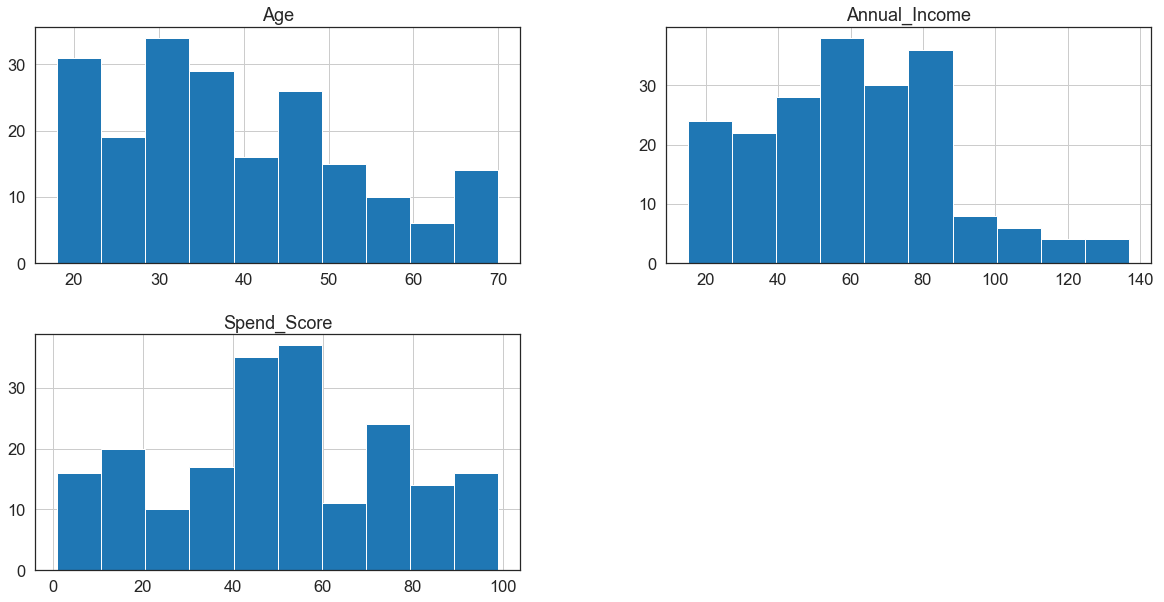

In [8]:
# Visualize the data

mall.hist()
plt.show();

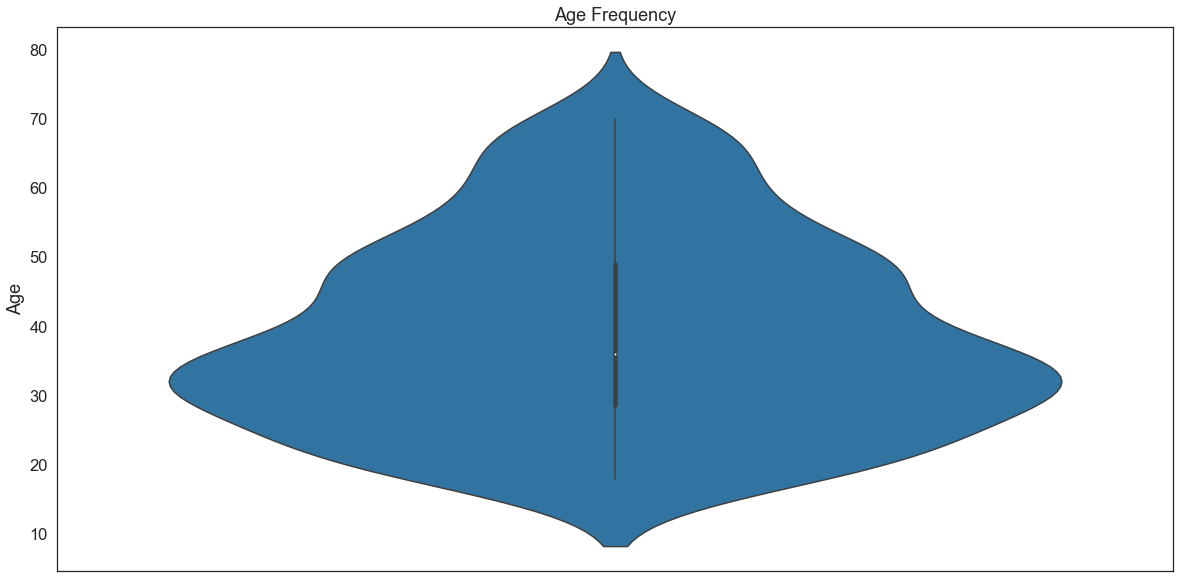

In [9]:
plt.title('Age Frequency')
sns.violinplot(y=mall['Age'])
plt.show();

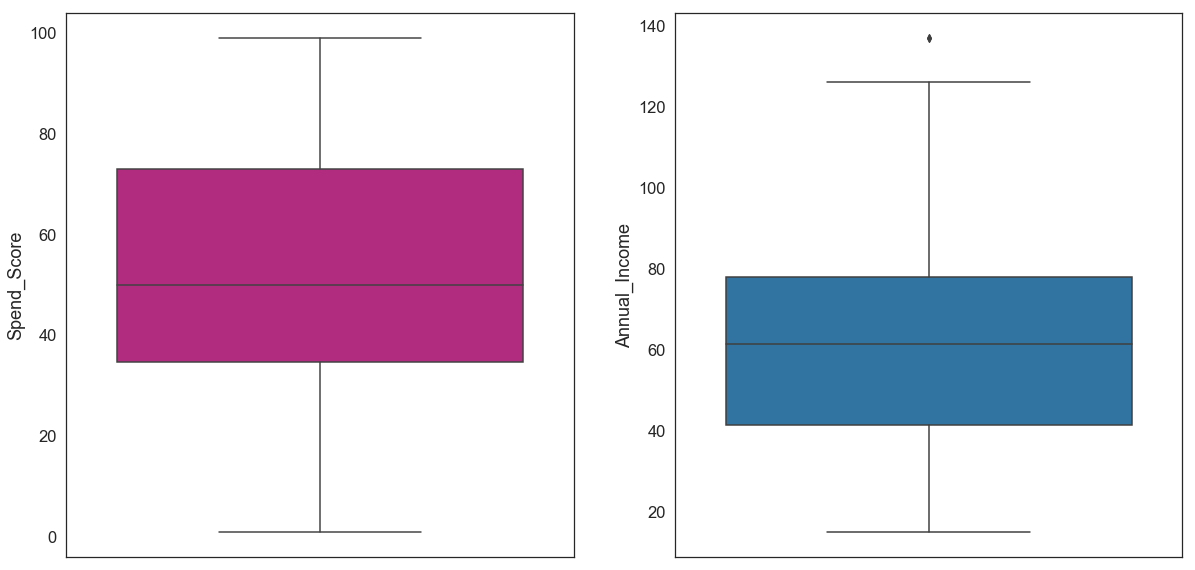

In [10]:
plt.subplot(1,2,1)
sns.boxplot(y=mall['Spend_Score'], color='mediumvioletred')
plt.subplot(1,2,2)
sns.boxplot(y=mall['Annual_Income'])
plt.show();

## How balanced is the dataset between genders?  

### The dataset is skewed toward the female customer base with women accounting for 56% of customers compared to 44% for men.

In [11]:
print(mall['Gender'].loc[mall['Gender'] == 'Female'].value_counts())
mall['Gender'].loc[mall['Gender'] == 'Male'].value_counts()

Female    112
Name: Gender, dtype: int64


Male    88
Name: Gender, dtype: int64

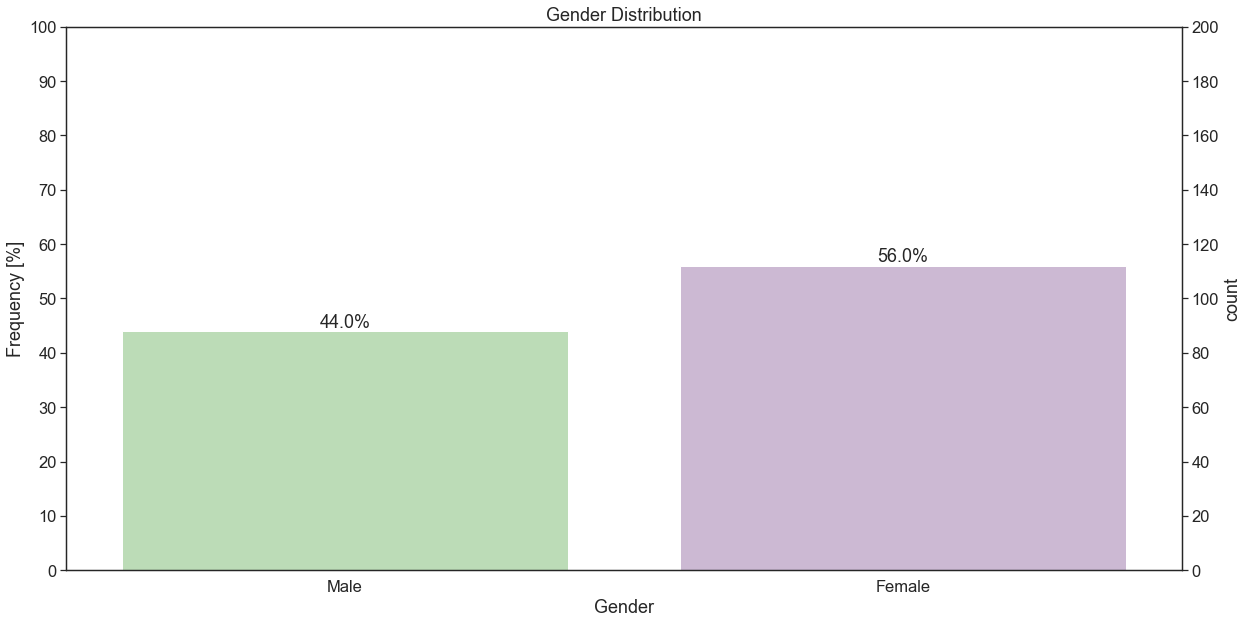

In [12]:
# plot gender distribution frequency

ax = sns.countplot(x='Gender', data=mall, palette='PRGn_r')
plt.title('Gender Distribution')
plt.xlabel('Gender')

ncount = len(mall)

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0, 100)
ax.set_ylim(0, ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

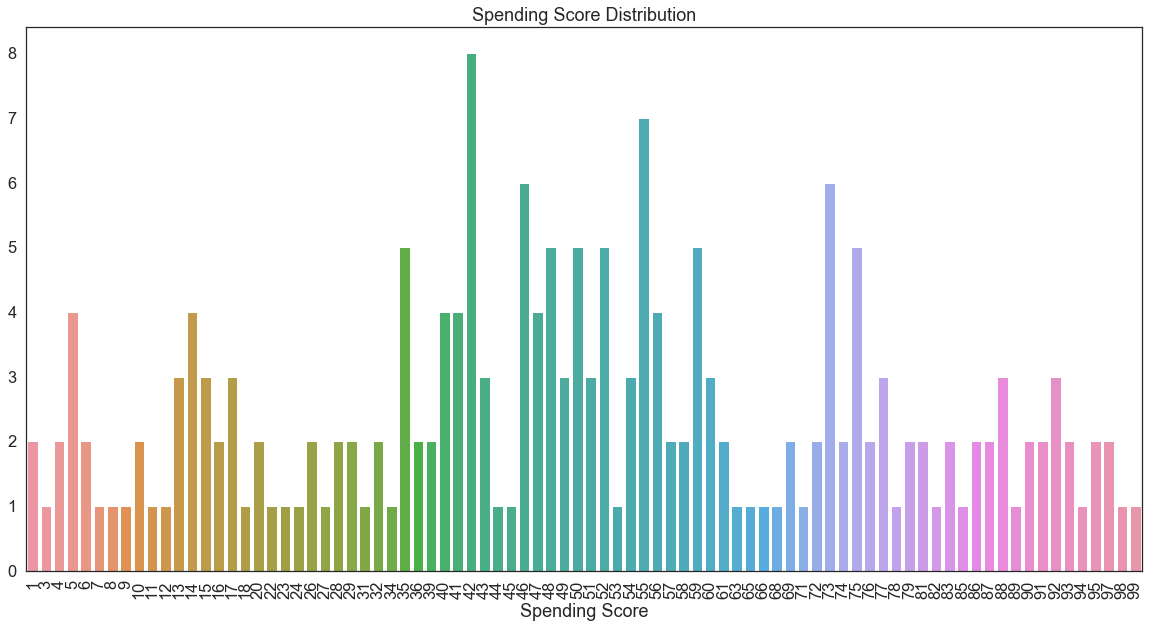

In [13]:
# spend score distribution by count

spend = mall.Spend_Score.value_counts()
sns.barplot(x=spend.index, y=spend.values)
plt.title('Spending Score Distribution')
plt.xlabel('Spending Score')
plt.xticks(rotation=90)
plt.show();

## Does spending score vary between genders?  

### Yes, women have a slightly higher spending score than men, however the disparity in gender distribution must be taken into account.

In [14]:
print('Mean Spending Score for Women:', mall['Spend_Score'].loc[mall['Gender'] == 'Female'].mean())
print('Mean Spending Score for Men:', mall['Spend_Score'].loc[mall['Gender'] == 'Male'].mean())

Mean Spending Score for Women: 51.526785714285715
Mean Spending Score for Men: 48.51136363636363


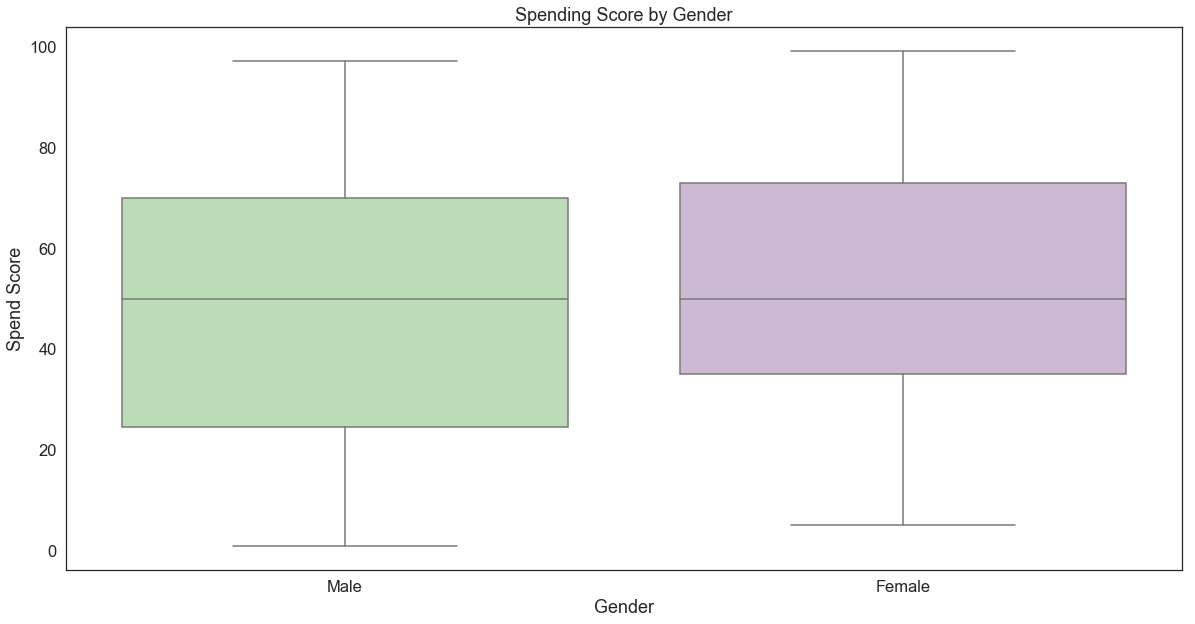

In [15]:
# spend score and age

ax = sns.boxplot(x='Gender', y='Spend_Score', data=mall, palette='PRGn_r')
plt.title('Spending Score by Gender')
ax.set(xlabel='Gender', ylabel='Spend Score')
plt.show();

## How are customers represented by age?  

### The largest age group is 26-35, followed by 18-25, with 36-45 being the third largest age group.

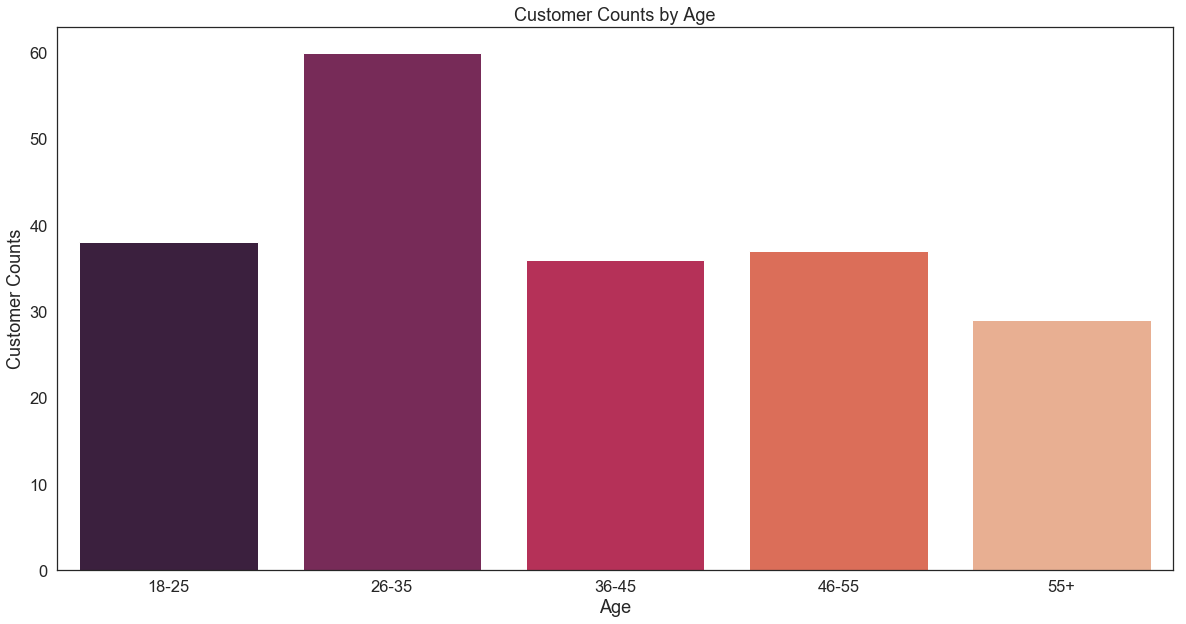

In [16]:
age18_25 = mall.Age[(mall.Age <= 25) & (mall.Age >= 18)]
age26_35 = mall.Age[(mall.Age <= 35) & (mall.Age >= 26)]
age36_45 = mall.Age[(mall.Age <= 45) & (mall.Age >= 36)]
age46_55 = mall.Age[(mall.Age <= 55) & (mall.Age >= 46)]
age55above = mall.Age[mall.Age >= 56]

x = ['18-25', '26-35', '36-45', '46-55', '55+']
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

sns.barplot(x=x, y=y, palette='rocket')
plt.title('Customer Counts by Age')
plt.xlabel('Age')
plt.ylabel('Customer Counts')
plt.show();

## How are customers represented by spending score?   

### The largest segment of customers have a spending score between 41-60, followed by 1-20, and customers with a spending score between 61-80 in 3rd place. 

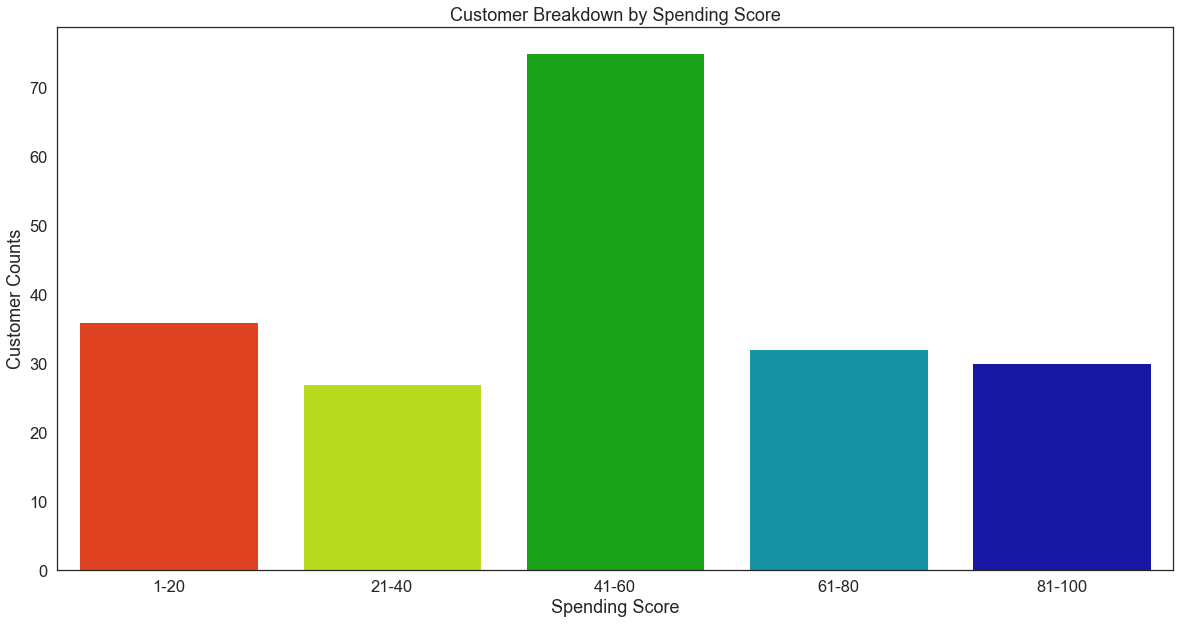

In [17]:
ss1_20 = mall['Spend_Score'][(mall['Spend_Score'] >= 1) & (mall['Spend_Score'] <= 20)]
ss21_40 = mall['Spend_Score'][(mall['Spend_Score'] >= 21) & (mall['Spend_Score'] <= 40)]
ss41_60 = mall['Spend_Score'][(mall['Spend_Score'] >= 41) & (mall['Spend_Score'] <= 60)]
ss61_80 = mall['Spend_Score'][(mall['Spend_Score'] >= 61) & (mall['Spend_Score'] <= 80)]
ss81_100 = mall['Spend_Score'][(mall['Spend_Score'] >= 81) & (mall['Spend_Score'] <= 100)]

ssx = ['1-20', '21-40', '41-60', '61-80', '81-100']
ssy = [len(ss1_20.values), len(ss21_40.values), len(ss41_60.values), len(ss61_80.values), len(ss81_100.values)]

sns.barplot(x=ssx, y=ssy, palette='nipy_spectral_r')
plt.title('Customer Breakdown by Spending Score')
plt.xlabel('Spending Score')
plt.ylabel('Customer Counts')
plt.show();

## How much are customers earning?  

### The majority of customers earn between 60,001 - 90,000 USD, followed by those earning 30,001 - 60,000 USD, and customers earning < 30,000 USD coming in third.

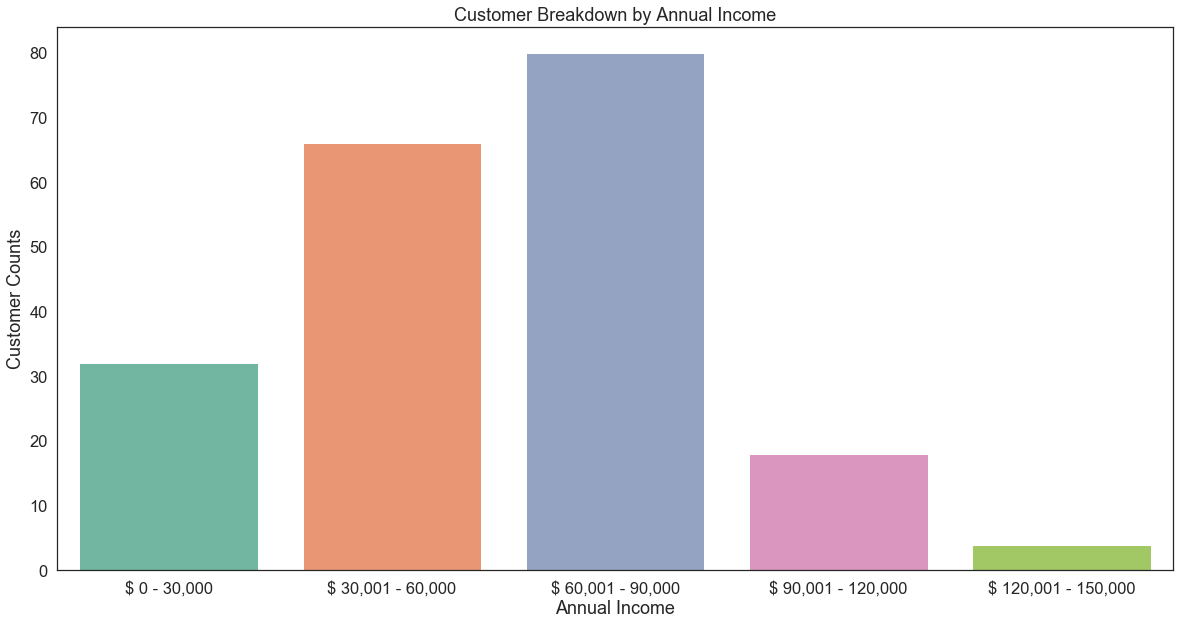

In [18]:
ai0_30 = mall['Annual_Income'][(mall['Annual_Income'] >= 0) & (mall['Annual_Income'] <= 30)]
ai31_60 = mall['Annual_Income'][(mall['Annual_Income'] >= 31) & (mall['Annual_Income'] <= 60)]
ai61_90 = mall['Annual_Income'][(mall['Annual_Income'] >= 61) & (mall['Annual_Income'] <= 90)]
ai91_120 = mall['Annual_Income'][(mall['Annual_Income'] >= 91) & (mall['Annual_Income'] <= 120)]
ai121_150 = mall['Annual_Income'][(mall['Annual_Income'] >= 121) & (mall['Annual_Income'] <= 150)]

aix = ['$ 0 - 30,000', '$ 30,001 - 60,000', '$ 60,001 - 90,000', '$ 90,001 - 120,000', '$ 120,001 - 150,000']
aiy = [len(ai0_30.values), len(ai31_60.values), len(ai61_90.values), len(ai91_120.values), len(ai121_150.values)]

sns.barplot(x=aix, y=aiy, palette='Set2')
plt.title('Customer Breakdown by Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Customer Counts')
plt.show();

## Is there a difference in annual income between men and women?

### Yes, men earn more than women, which is significant as this dataset is biased toward women in terms of gender distribution.

In [19]:
print("Mean Annual Income ($ k) for Women:", mall['Annual_Income'].loc[mall['Gender'] == 'Female'].mean())
print("Mean Annual Income ($ k) for Men:", mall['Annual_Income'].loc[mall['Gender'] == 'Male'].mean())

Mean Annual Income ($ k) for Women: 59.25
Mean Annual Income ($ k) for Men: 62.22727272727273


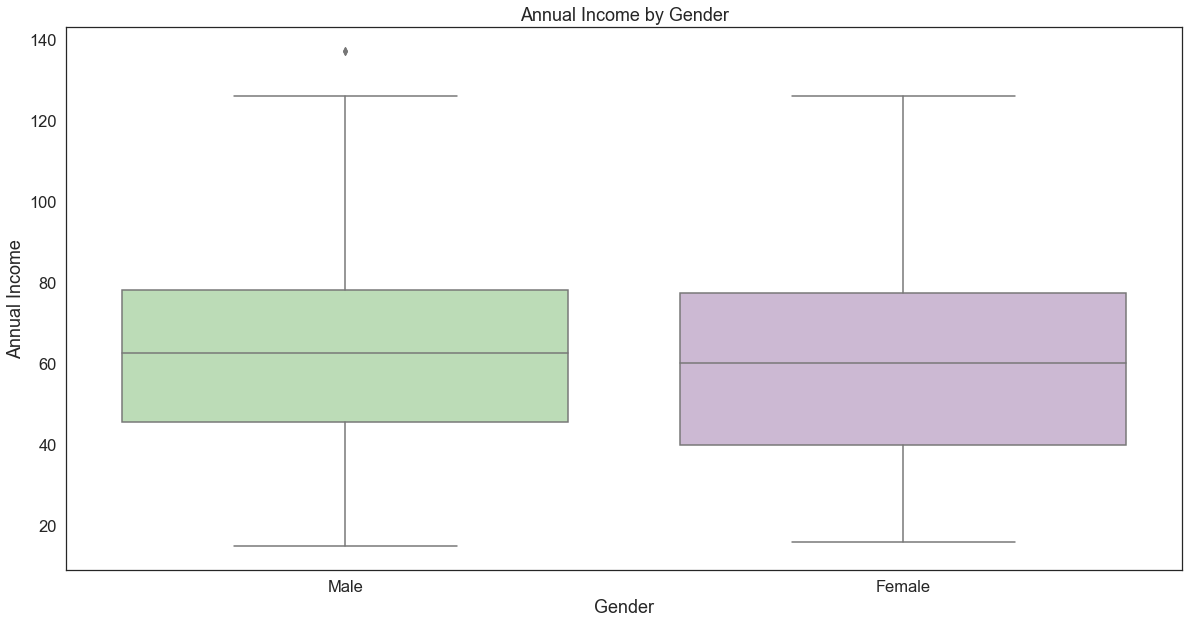

In [20]:
# spend score and age

ax = sns.boxplot(x='Gender', y='Annual_Income', data=mall, palette='PRGn_r')
plt.title('Annual Income by Gender')
ax.set(xlabel='Gender', ylabel='Annual Income')
plt.show();

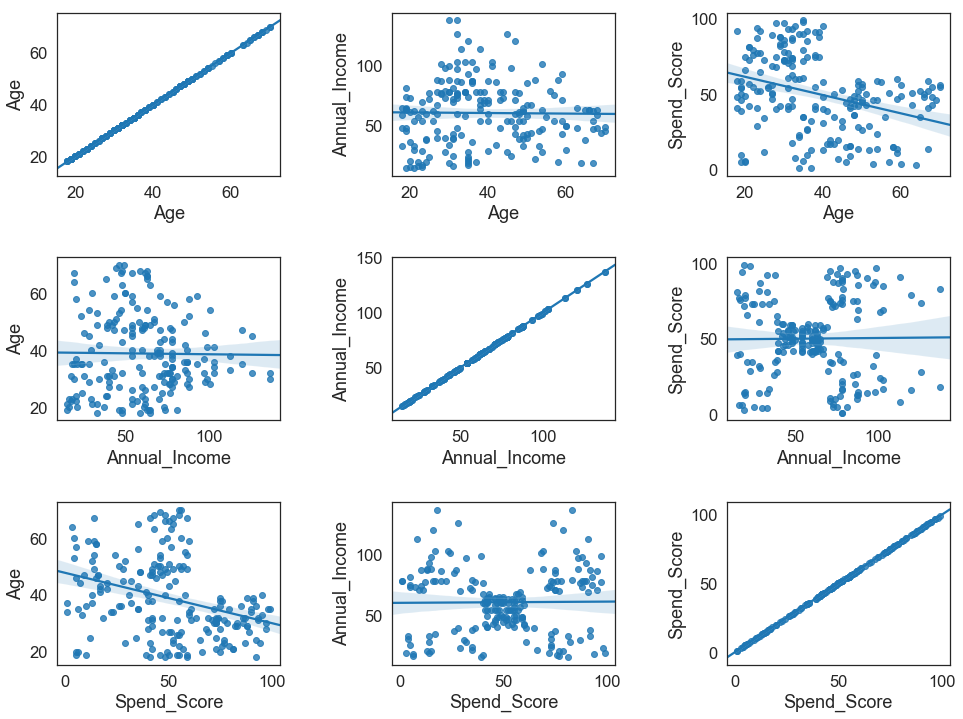

In [21]:
# use a regression plot to see correlations

plt.figure(1 , figsize = (16 , 12))
n = 0 
for x in ['Age' , 'Annual_Income' , 'Spend_Score']:
    for y in ['Age' , 'Annual_Income' , 'Spend_Score']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = mall)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show();

In [22]:
# Age and Spending Score

X = mall[['Age' , 'Spend_Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)

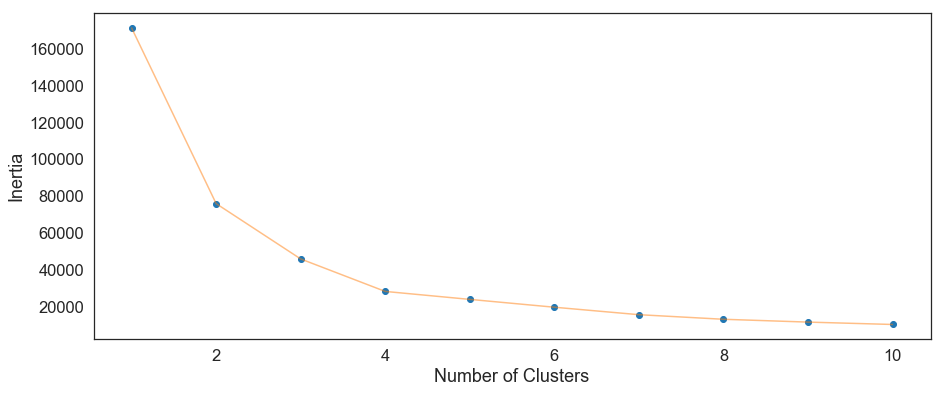

In [23]:
# plot for optimal number of clusters

plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [24]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

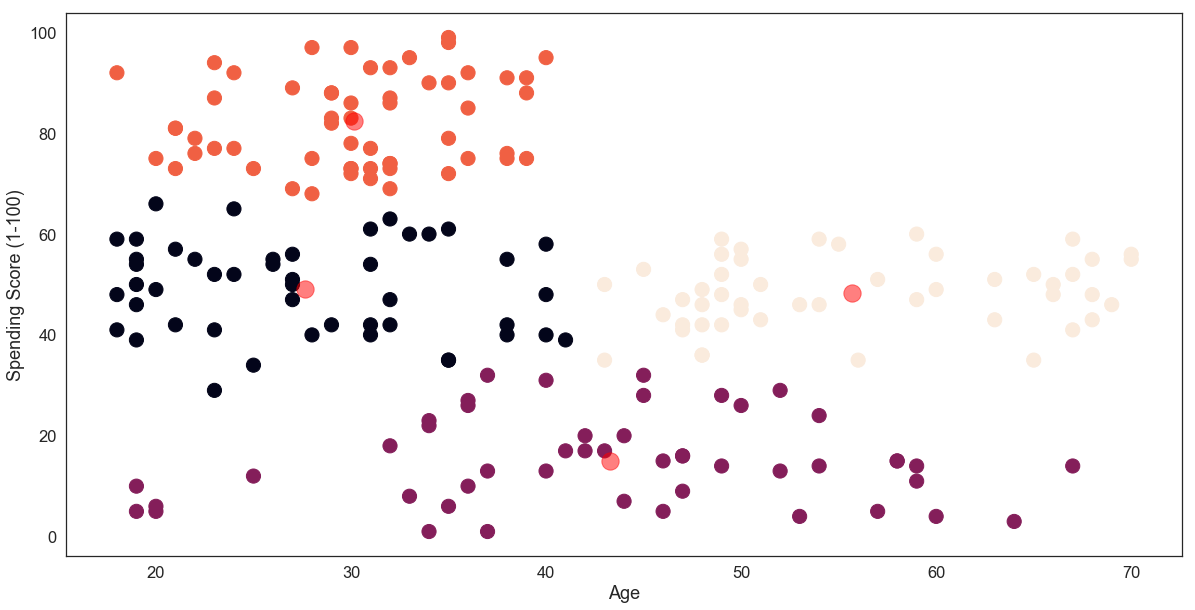

In [25]:
# optimal spend score to target

plt.clf()
plt.scatter( x = 'Age' ,y = 'Spend_Score' , data = mall , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Age')
plt.show()

In [26]:
# Annual Income and Spending Score

X2 = mall[['Annual_Income' , 'Spend_Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

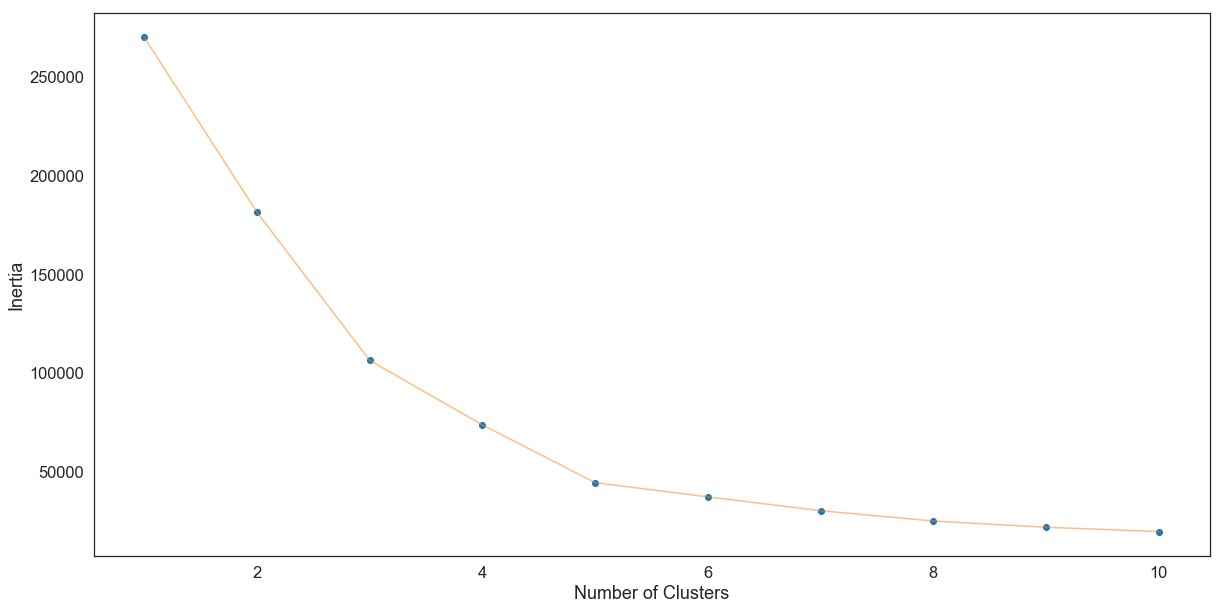

In [27]:
# plot for optimal number of clusters

plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show();

In [28]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

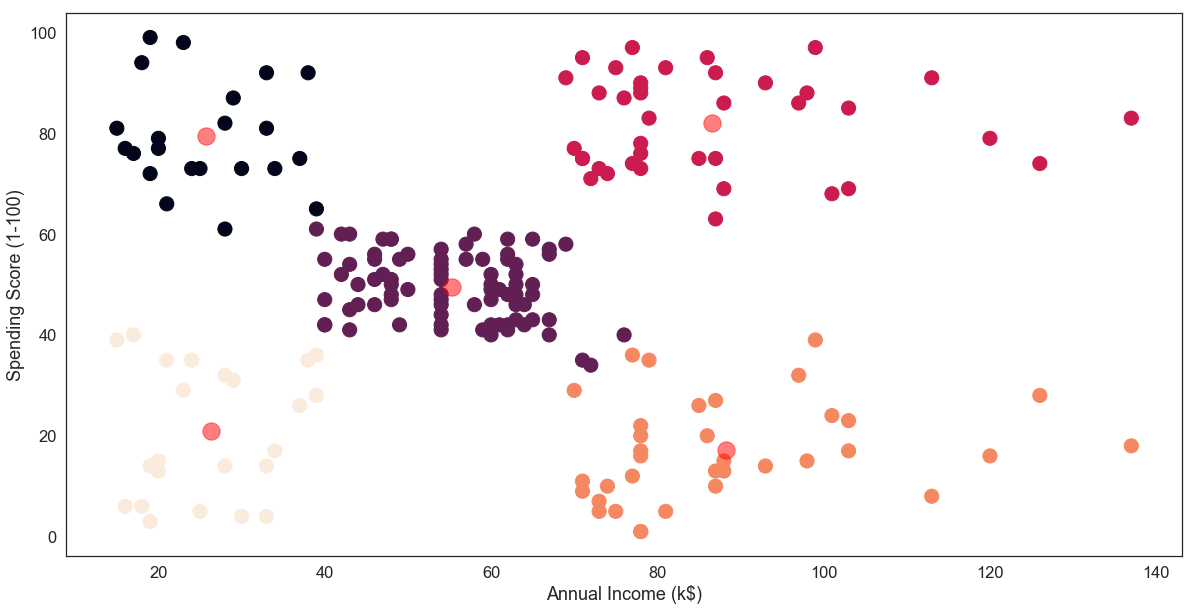

In [29]:
plt.clf()
plt.scatter( x = 'Annual_Income', y = 'Spend_Score' , data = mall , c = labels2 , 
            s = 200 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 300 , c = 'red' , alpha = 0.5)
plt.ylabel('Spending Score (1-100)') , plt.xlabel('Annual Income (k$)')
plt.show();